# INTRODUCTION

This notebook looks into developing an end-to-end machine learning pipeline in Python to predict the probability of default (Credit risk modelling concept) using a financial dataset.

We're going to take the following approach:

- Problem definition
- Data
- Evaluation
- Features
- Modelling
- Experimentation

### Problem Definition

- Given Financial details about a person, can we predict whether or not they are likely to default on a loan?

### Evaluation

- If we can reach a considerable good roc-auc score in classification.


# Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.


In [170]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve




### Load Data


In [171]:
 
data = pd.read_csv('data_science_competition_2024.csv')
df = pd.read_csv('data_science_competition_2024.csv')
df.columns
print(df.shape )# (rows, columns)
df.head(4)


(100000, 21)


,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,...,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,...,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,...,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,...,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,...,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default


#### class balance


# PRIMARY DATA CLEANING


### Feature data type correction


In [172]:
df.dtypes

Unnamed: 0                int64
loan_id                  object
gender                   object
disbursemet_date         object
currency                 object
country                  object
sex                      object
is_employed                bool
job                      object
location                 object
loan_amount             float64
number_of_defaults        int64
outstanding_balance     float64
interest_rate           float64
age                       int64
number_of_defaults.1      int64
remaining term           object
salary                  float64
marital_status           object
age.1                     int64
Loan Status              object
dtype: object

In [173]:
# function to correct spelling
def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel



In [174]:
#Convert remaining term feature to consitenly become numeric

# Convert to string to handle non-numeric characters
df['remaining term'] = df['remaining term'].astype(str)

# Remove underscores and extra spaces
df['remaining term'] = df['remaining term'].str.replace('_', '').str.strip()

# Convert back to numeric if all values are intended to be numeric
df['remaining term'] = pd.to_numeric(df['remaining term'], errors='coerce')


df['remaining term'].dtype

dtype('int64')

## Feature category spelling correction


In [175]:
print(df['location'].value_counts())
#incorrect spellings for locations


location
Harare               8338
Bulawayo             8078
Mutare               8062
Gweru                7803
Masvingo             7476
                     ... 
 Redcliff               1
Victoria Falls          1
Victoria Falls          1
   Gokwe                1
Gokwe                   1
Name: count, Length: 157, dtype: int64


In [176]:
#location feature textual normalization
df['location'] = df['location'].str.strip()

# convert lowercase
df['location'] = df['location'].str.lower()

# Create a dictionary to map incorrect variations to correct values
mapping = {
    'harare': 'Harare',
    'bulawayo': 'Bulawayo',
    'mutare': 'Mutare',
    'gweru': 'Gweru',
    'masvingo': 'Masvingo',
    'marondera': 'Marondera',
    'rusape': 'Rusape',
    'chivhu': 'Chivhu',
    'plumtree': 'Plumtree',
    'beitbridge': 'Beitbridge',
    'chipinge': 'Chipinge',
    'chimanimani': 'Chimanimani',
    'kwekwe': 'Kwekwe',
    'chiredzi': 'Chiredzi',
    'kadoma': 'Kadoma',
    'nyanga': 'Nyanga',
    'karoi': 'Karoi',
    'shurugwi': 'Shurugwi',
    'zvishavane': 'Zvishavane',
    'gokwe': 'Gokwe',
    'kariba': 'Kariba',
    'victoria falls': 'Victoria Falls',
    'redcliff': 'Redcliff',
    'hwange': 'Hwange'
}

# Replace incorrect values using the mapping dictionary
df['location'] = df['location'].replace(mapping)



print(df['location'].value_counts())
# the locations are now normalized


location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64


In [177]:
print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())
#Textual normalization required




df['Category'] = df['location'].apply(lambda x: 
                                     
                                     2 if x in [
    
    'Karoi',
    'Hwange',
     'Chiredzi',
    'Gokwe',
    
   
    'Shurugwi',
    'Victoria Falls',
    
    ] else 0 if x in ['Nyanga', 'Chivhu', 'Kadoma', 'Marondera', 'Gweru', 'Masvingo', 'Harare', 'Bulawayo', 'Mutare'] else 1 )





currency
USD     99980
$USD       20
Name: count, dtype: int64

country
Zimbabwe    99787
zimbabwe      100
Zim            13
Name: count, dtype: int64

job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64


In [178]:
#correcting feature categories

def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel
    return df.loc[:, column].value_counts()

consistent_column_spelling('currency', '$USD', 'USD')
consistent_column_spelling('job', 'Data Scintist', 'Data Scientist')
consistent_column_spelling('job', 'SoftwareDeveloper', 'Software Developer')
consistent_column_spelling('country', 'Zimbabwe', 'zimbabwe')
consistent_column_spelling('country', 'Zim', 'zimbabwe')

print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())

currency
USD    100000
Name: count, dtype: int64

country
zimbabwe    99900
Name: count, dtype: int64

job
Engineer              16524
Software Developer    15496
Nurse                 15284
Data Analyst          13204
Doctor                12186
Teacher                8950
Accountant             7802
Data Scientist         3556
Lawyer                 2862
Name: count, dtype: int64


Drop unnecessary and redundant columns


In [179]:


# Drop unnecessary columns
df.drop(['loan_id', 'Unnamed: 0', 'age.1', 'number_of_defaults.1', 'sex'], axis=1, inplace=True)



# EXPLORATORY DATA ANALYSIS

#### The goal here is to find out more about the data and become a subject matter expert.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?


In [180]:
df.describe()

,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,Category
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,31120.000000,0.441970,36964.909763,0.210435,43.57069,52.881870,2781.804324,0.477270
std,15895.093631,0.688286,10014.758477,0.018725,4.86376,11.985833,696.450055,0.634214
min,1000.000000,0.000000,0.000000,0.100000,21.00000,0.000000,250.000000,0.000000
25%,21000.000000,0.000000,29625.227472,0.200000,40.00000,45.000000,2273.929349,0.000000
50%,31000.000000,0.000000,35063.852394,0.210000,44.00000,52.000000,2665.441567,0.000000
75%,40000.000000,1.000000,42133.388817,0.220000,47.00000,61.000000,3146.577655,1.000000
max,273000.000000,2.000000,150960.000000,0.300000,65.00000,120.000000,10000.000000,2.000000


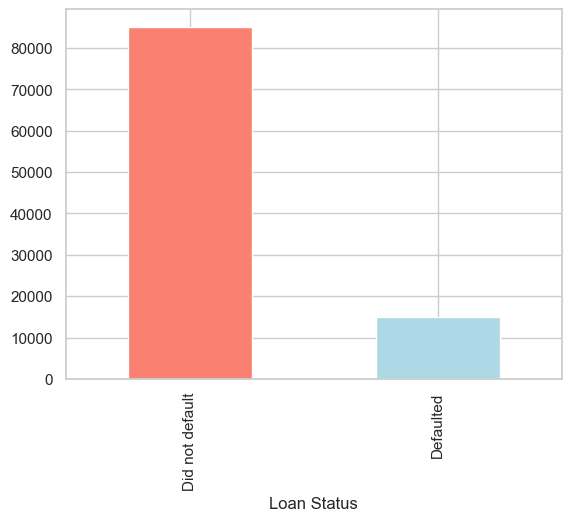

In [181]:

df['Loan Status'].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [182]:
print(df.shape)
print()
print(df.isna().sum())



(100000, 17)

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
Category                  0
dtype: int64


## Structure overview

- The dataset is has 100000 rows and 21 columns.
- It has both categorical and numerical features.
- It is extremely imbalanced
- It has missing values in the job, location and country columns


### Univariate relationships

- identify the distribution of the individual features


In [183]:
#univariate hist plots
# fig, (ax,ax1) = plt.subplots(2,3,figsize=(20,8))
# plt.suptitle('DISTRIBUTION PLOTS')
# sns.histplot(df,x= 'age', bins=100,kde=True, ax=ax[0], color='darkcyan');
# sns.histplot(df,x = 'interest_rate', bins=100,kde=True, ax=ax[1], color='salmon');
# sns.histplot(df, x = 'salary', bins=100,kde=True, ax=ax[2], color='darkviolet');
# sns.histplot(df, x = 'outstanding_balance', bins=100,kde=True, ax=ax1[0], color='yellow');
# sns.histplot(df, x = 'remaining term', bins=100,kde=True, ax=ax1[1], color='gold');
# sns.histplot(df, x = 'loan_amount', bins=100,kde=True, ax=ax1[2], color='darkgoldenrod');

# fig, ax = plt.subplots(1,4,figsize=(20,5))
# plt.suptitle('BOX PLOTS')
# sns.boxplot(df, x='loan_amount', ax=ax[0]);
# sns.boxplot(df, x='age', ax=ax[1]);
# sns.boxplot(df, x='outstanding_balance', ax=ax[2]);
# sns.boxplot(df, x='salary', ax=ax[3]);


#### OBSERVATIONS

- age, interest rate are uniformly distributed.
- outstanding balance, loan amount, salary and outstanding balance are skewed.
- Loan amount has a sharp peak at the start.
- outstanding balance and salary have considerable outliers.


#### Further investigate the sharp peak on loan amount distribution


In [184]:
# pd.set_option('display.max_colwidth', None)
# # print(df['remaining term'].value_counts().to_string())
# df[['loan_amount', 'outstanding_balance', 'remaining term', 'salary', 'age', 'interest_rate']].groupby((pd.cut(df['remaining term'], bins=np.arange(0, 150, 10)))).size()

In [185]:
# plt.figure(figsize=(10, 6))
# sns.histplot(df[df['loan_amount']<100000]['loan_amount'], kde=True)
# plt.title('Distribution of Loan Amounts below 10000')
# plt.show()

- There is indeed a sharp peak at around $5000. Indicates a high number of points there.


### TEST IF THE THESE NUMERICAL FEATURES ARE NORMALLY DISTRIBUTED USING QQPLOT


In [186]:
# import statsmodels.graphics.gofplots as sm

# plt.figure(figsize = (20,16))

# fig, ((ax, ax1), (ax2,ax3), (ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize = (15,12))
       
# sm.qqplot(df['interest_rate'], line='s', ax=ax)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax.set_ylabel('interest rates Quantiles')

# sm.qqplot(df['salary'], line='s', ax=ax1)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax1.set_ylabel('salary Quantiles')

# sm.qqplot(df['age'], line='s', ax=ax2)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax2.set_ylabel('age Quantiles')

# sm.qqplot(df['loan_amount'], line='s', ax=ax3)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax3.set_ylabel('loan amount Quantiles')

# sm.qqplot(df['remaining term'], line='s', ax=ax4)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax4.set_ylabel('remaining term Quantiles')
# sm.qqplot(df['outstanding_balance'], line='s', ax=ax5)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax5.set_ylabel('outstanding balance Quantiles')
       

LOAN AMOUNT AND SALARY AND OUTSTANDING BALANCE ARE HIGHLY DEVIATING AWAY FROM NORMAL DISTRIBUTION


## CATEGORICAL FEATURE DISTRIBUTION


## bivariate relationships


In [187]:
# fig, (ax, ax1, ax2) = plt.subplots(3,2,figsize=(15,18))

# sns.countplot(df,x= 'gender', ax=ax[0], palette='magma', hue='Loan Status');
# sns.countplot(df,x= 'marital_status', ax=ax[1], palette='spring', hue='Loan Status');
# sns.countplot(df,x= 'number_of_defaults', ax=ax1[0], palette='rocket', hue='Loan Status');
# sns.countplot(df,x= 'job', ax=ax1[1], palette='crest', hue='Loan Status');
# sns.countplot(df,x= 'location', ax=ax2[0], palette='mako', hue='Loan Status', );
# sns.countplot(df,x= 'is_employed', ax=ax2[1], palette='cividis', hue='Loan Status', );
# ax2[0].set_xticks(ax2[0].get_xticks());
# ax1[1].set_xticks(ax1[1].get_xticks());
# ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=45, ha='right');
# ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=45, ha='right');
# plt.subplots_adjust(hspace=0.4)

### OBSERVATIONS

- Towns like Chiredzi, Shurugwi, Gokwe, Karoi, Hwange and Kwekwe have high probability of defaulting
- Cities like Harare, Bulawayo, 'Mutare', 'Gweru have low probability of Default'
- People who are married are less likely to deafulted
- People with less previous defaults are less likely to deasex is roughly balanced
- There is an additional unlabeled marital status category
- Lawyers and Accountants have high probability of defaulting


In [188]:

# # Create another figure
# plt.figure(figsize=(10, 6))
# fig, ((ax, ax1), (ax2,ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize = (15,12))

# sns.scatterplot(data=df, x='age', y= 'interest_rate', hue= 'Loan Status', ax= ax);
# sns.scatterplot(data=df, x='age', y= 'loan_amount', hue= 'Loan Status', ax= ax1);
# sns.scatterplot(data=df, x='age', y= 'outstanding_balance', hue= 'Loan Status', ax= ax2);
# sns.scatterplot(data=df, x='age', y= 'salary', hue= 'Loan Status', ax= ax3);
# sns.scatterplot(data=df, x='salary', y= 'loan_amount', hue= 'Loan Status', ax= ax4);
# sns.scatterplot(data=df, x='salary', y= 'interest_rate', hue= 'Loan Status', ax= ax5);
# sns.scatterplot(data=df, x='interest_rate', y= 'outstanding_balance', hue= 'Loan Status', ax= ax6);
# sns.scatterplot(data=df, x='loan_amount', y= 'outstanding_balance', hue= 'Loan Status', ax= ax7);


In [189]:
# fig, (ax, ax1, ax2, ax3, ax4,ax5) = plt.subplots(6,2,figsize=(30,30))
# plt.suptitle('BIVARIATE ANALYSIS (HUE=LOAN STATUS)', fontsize=20)
# # plt.tight_layout(2)

# sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax[0]);
# sns.lineplot(data=df, x='interest_rate', y='loan_amount', hue='Loan Status', lw=2, ax=ax[1]);
# sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax1[0]);
# sns.lineplot(data=df, x='interest_rate', y='age', hue='Loan Status', lw=2, ax=ax1[1]);
# sns.lineplot(data=df, x='interest_rate', y='remaining term', hue='Loan Status', lw=2, ax=ax2[0]);
# sns.lineplot(data=df, x='age', y='remaining term', hue='Loan Status', lw=2, ax=ax2[1]);
# sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax3[0]);
# sns.lineplot(data=df, x='interest_rate', y='salary', hue='Loan Status', lw=2, ax=ax3[1]);
# sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax4[0]);
# sns.lineplot(data=df, x='loan_amount', y='salary', hue='Loan Status', lw=2, ax=ax4[1]);
# sns.lineplot(data=df, x='remaining term', y='salary', hue='Loan Status', lw=2, ax=ax5[0]);
# sns.lineplot(data=df, x='remaining term', y='loan_amount', hue='Loan Status', lw=2, ax=ax5[1]);

### OBSERVATIONS

1. The age vs loan_amount seems to be to seperate classes well in the first half
2. The interest rate vs loan_amount seems to be to seperate classes well in the forst 3 quarter.
3. Age is also a good seperater with salary.
4. Remaining term is also good in the last quarter.


#### multivariate relationships


<Axes: >

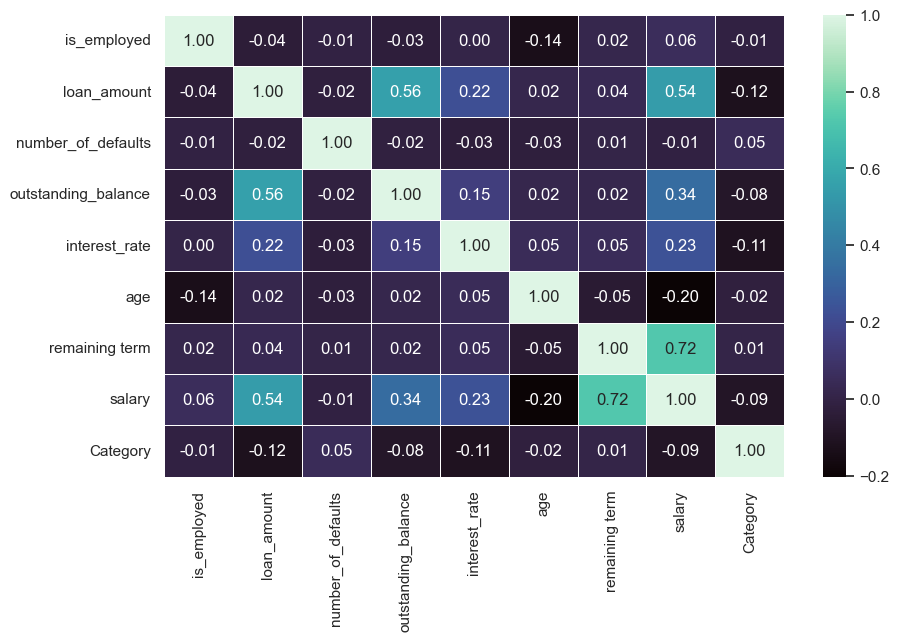

In [190]:
corrData = df.loc[:, [col for col in df if df[col].dtype not in ['category', 'object']]]
plt.figure(figsize=(10,6))
sns.heatmap(corrData.corr(), annot= True, linewidths=0.5,
                 fmt=".2f",
                 cmap="mako")


### THE SEEMS TO BE SOME TIGHT CORRELATION BETWEEN SOME FEATURES

`salary` and `loan amount`,  
`salary` and `loan remaining term`,
`loan amount` and `outstanding_balance`


# SECONDARY DATA HANDLING

## HANDLING MISSING VALUES


In [191]:
df.isna().sum()

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
Category                  0
dtype: int64

In [192]:
# df.loc[(df.job.isna())& (df.loan_amount>60000), 'job'] = 'Data Scientist'
# fill job with mode job Engineer
df.job.fillna('Data Analyst',inplace= True)
df.location.fillna('unknown',inplace= True)
# df.dropna(subset=['location'], inplace=True)

df.isna().sum()

C:\Users\Augah\AppData\Local\Temp\ipykernel_4472\2393010354.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.job.fillna('Data Analyst',inplace= True)
C:\Users\Augah\AppData\Local\Temp\ipykernel_4472\2393010354.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

gender                   0
disbursemet_date         0
currency                 0
country                100
is_employed              0
job                      0
location                 0
loan_amount              0
number_of_defaults       0
outstanding_balance      0
interest_rate            0
age                      0
remaining term           0
salary                   0
marital_status           0
Loan Status              0
Category                 0
dtype: int64

## EARLIER

- Earlier we discovered that the marital status feature has a category called " " white space.
- We want to predict this category into its corresponding valid category using the XGB MODEL.
- We are going to use the custom made predict feature class.


In [193]:

print(df['marital_status'].value_counts())


marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64


## DATA PREPROCESSING


In [194]:
# convert the disbursement date to right date and time format.
import pandas as pd

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

In [195]:
# encode categorical variables

from sklearn.preprocessing import LabelEncoder


df['gender'] = df['gender'].map({"other":1, "female": 0,'male':2}).astype('int')




label_encodings = {}
label_models = {}

# Initialize the LabelEncoder
le = LabelEncoder()

# List of categorical features
categorical_features = ['currency', 'country', 'job', 'location']

# Encode each categorical feature and store the mappings
for cat in categorical_features:
    df[cat] = le.fit_transform(df[cat])
    label_models[cat] = le.fit(df[cat])
    label_encodings[cat] = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit([ 'Defaulted','Did not default'])
if df['Loan Status'].dtype != 'int64':
    df['Loan Status'] = df['Loan Status'].map({'Did not default': 0, 'Defaulted': 1}).astype('int')
label_models

{'currency': LabelEncoder(),
 'country': LabelEncoder(),
 'job': LabelEncoder(),
 'location': LabelEncoder()}

## EARLIER

- Earlier we discovered that the marital status feature has a category called " " white space.
- We want to predict this category into its corresponding valid category using an XGB MODEL.
- We are going to use the custom made predict feature class.


In [204]:
from sklearn.preprocessing import LabelEncoder
import importlib
import predict_feature
importlib.reload(predict_feature)
from predict_feature import Predict_Marital
import xgboost as xgb



class Transform_data():
    def __init__(self, data, le_models):
        self.le = le
        self.data = data


    def transform_cat(self):
        categorical_features = ['currency', 'country', 'job', 'location']

        # Encode each categorical feature and store the mappings
        for cat in categorical_features:
            self.data[cat] = le_models[cat].transform(self.data[cat])
            label_encodings[cat] = dict(zip(le.classes_, le.transform(le.classes_)))
        le.fit([ 'Defaulted','Did not default'])
        if self.data['Loan Status'].dtype != 'int64':
            self.data['Loan Status'] = self.data['Loan Status'].map({'Did not default': 0, 'Defaulted': 1}).astype('int')

        return self.data    

    def predict_marital(self):
        mdl = Predict_Marital(self.data)
        mdl.train()

        preds, feature_importances = mdl.predict()

        self.data.loc[self.data.marital_status  == ' ', 'marital_status']

        self.data.loc[self.data.marital_status  == ' ', 'marital_status'] =pd.DataFrame(preds)[0].map({0:'single', 1:'married', 2:'divorced'}).to_numpy()
        self.data['marital_status'] = self.data['marital_status'].map({'single':0, 'married':1, 'divorced': 2}).astype('int')

        print(self.data.marital_status.value_counts())

    def fit_transform(self): 
        a = self.data
        a = self.predict_marital()

        return a  



b = Transform_data(df.drop(columns='disbursemet_date'),label_models)
b.fit_transform()       


score: 0.9021935483870968
marital_status
1    46189
2    27295
0    26516
Name: count, dtype: int64


In [ ]:
import importlib
import predict_feature
importlib.reload(predict_feature)
from predict_feature import Predict_Marital
import xgboost as xgb





mdl = Predict_Marital(df.drop('disbursemet_date', axis =1))
mdl.train()

preds, feature_importances = mdl.predict()

df.loc[df.marital_status  == ' ', 'marital_status']

df.loc[df.marital_status  == ' ', 'marital_status'] =pd.DataFrame(preds)[0].map({0:'single', 1:'married', 2:'divorced'}).to_numpy()
df['marital_status'] = df['marital_status'].map({'single':0, 'married':1, 'divorced': 2}).astype('int')

print(df.marital_status.value_counts())


score: 0.8994064516129032
marital_status
1    46198
2    27291
0    26511
Name: count, dtype: int64


In [ ]:
# DATA SEPERATION



X = df.drop(['Loan Status', 'disbursemet_date'], axis=1)
y = df['Loan Status']


X


,gender,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Category
0,0,0,0,True,8,0,39000.0,0,48653.011473,0.22,37,47,3230.038869,1,1
1,1,0,0,True,8,8,27000.0,2,28752.062237,0.20,43,62,3194.139103,0,0
2,1,0,0,True,6,7,35000.0,1,44797.554126,0.22,43,57,3330.826656,1,0
3,0,0,0,True,3,20,24000.0,0,35681.496413,0.23,47,42,2246.797020,2,1
4,2,0,0,True,6,3,19000.0,0,34156.055882,0.20,42,45,2310.858441,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,0,0,False,1,14,36000.0,1,32968.219881,0.21,52,29,1803.818844,0,0
99996,1,0,0,True,4,2,43000.0,0,48652.554897,0.23,50,57,3056.127917,1,1
99997,0,0,0,True,1,10,48000.0,0,34266.224130,0.23,43,53,3535.599759,1,0
99998,2,0,0,True,4,16,36000.0,2,71546.024917,0.22,49,59,3082.407123,0,0


## FEATURE ENGINEERING

#### CREATE NEW FEATURES


In [ ]:
## function to encode a categorical feature ordinaly with respect to another feature with mean
def group_sort_map(X, groupby_column, sort_by_column):
    """
    Group X by a given column, calculate the mean, sort by another column,
    and map the groupby column to its corresponding index after sorting.

    Parameters:
    - X (pd.DataFrame): The input DataFrame to process.
    - groupby_column (str): The column name to group by.
    - sort_by_column (str): The column name to sort by.

    Returns:
    - sorted_groupby_df (pd.DataFrame): The grouped and sorted DataFrame.
    - location_to_index (dict): A mapping of groupby column values to their sorted indices.
    """
    
    # 1. Group by the specified column and calculate the mean
    groupby_df = X.groupby(groupby_column).mean()
    
    # 2. Sort the resulting DataFrame by the specified column
    sorted_groupby_df = groupby_df.sort_values(by=sort_by_column)
    
    # 3. Map the groupby column to its corresponding index after sorting
    feature_to_index = {feature: index for index, feature in enumerate(sorted_groupby_df.index)}
    index_to_feature = {index: feature for index, feature in enumerate(sorted_groupby_df.index)}
    
    
    return  feature_to_index, index_to_feature

# ordinally encode location by loan_amount mean per location
location_map, ind_to_feature_location=group_sort_map(X= X, groupby_column='location', sort_by_column='loan_amount' )
X['location'] = X['location'].map(location_map).astype('int')

# ordinally encode location by loan_amount mean per location
job_map, ind_to_feature_job=group_sort_map(X= X, groupby_column='job', sort_by_column='salary' )
X['job'] = X['job'].map(job_map).astype('int')



In [ ]:
# independent binary features for loan_amount === 5000 and greater than 75000
X['loan_equal_5000'] = np.where(X.loan_amount==5000,1,0)
X['loan_>_75000'] = np.where(X.loan_amount>75000,1,0)

In [ ]:
# create a feature for loan amount per job
X = X.assign(total_loan_amount_per_job=X.groupby('job')['loan_amount'].transform('mean'))

### Create new feature to capture job and location relationship
X['job_location_interact'] = np.log1p(np.sqrt(X['job']))/(X['location']+1)

#### SPLIT THE DATA


##### Add the location threshold classification in train data only to avoid data leakage since

##### since we are using the target varible


In [ ]:
# Create a feature for threshold classification of locations
def location_thresh_classification(X_features, labels, apply_data, threshold= 0.2):
    X_features = X_features.copy()
    X_features['y'] = labels
    location_ratios = X_features.groupby('location')['y'].mean()
    location_ratios = location_ratios / (1 - location_ratios)
  
    ## Define a threshold for classification (example: 0.2)
    threshold = 0.2
    #drop the labels if features equal to the apply
    if apply_data.shape == X_features.shape:
        X_features.drop('y',axis = 1, inplace = True)
    ## Classify locations based on imbalance ratio

    X_features.drop (columns ='y', axis = 1, inplace = True)
    apply_data['location_class'] = apply_data['location'].map(lambda loc: 1 if location_ratios[loc] < threshold else 0)
    return apply_data


# FEATURE SELECTION


CHECKING FOR ASSOCIATION BETWEEN CATEGORICAL VARIABLES USING CHI SQUARE AND P_VALUE


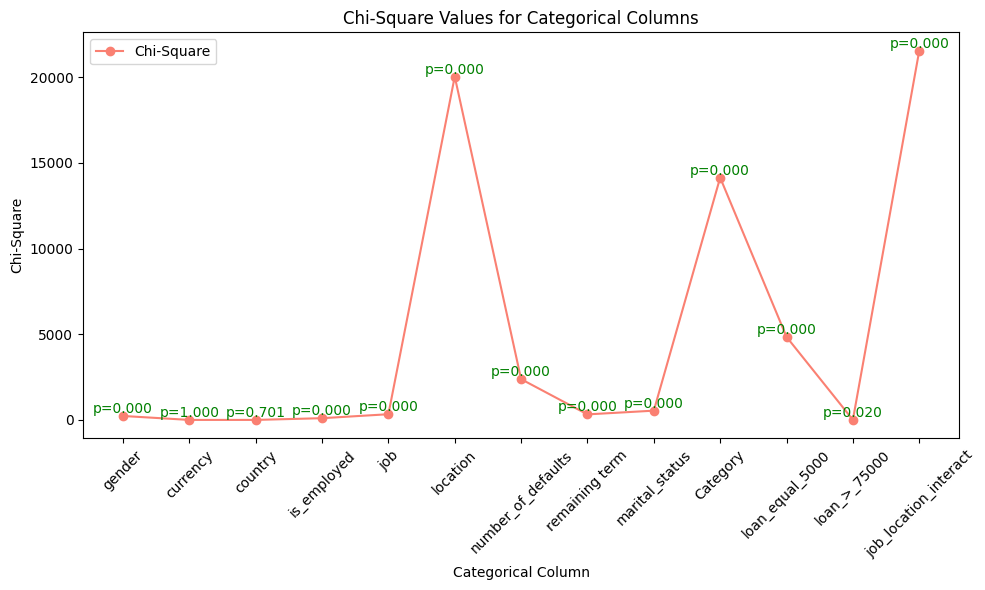

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Assume X and y are already defined and preprocessed dataframes
# Initialize the output dictionary
out = {'chi': [], 'p_value': [], 'col': []}

# Iterate over the categorical columns
for i in (X.columns[~X.columns.isin(['loan_amount', 'outstanding_balance', 'salary', 'total_loan_amount_per_job', 'age', 'interest_rate', 'remaining_term'])]):
    # Create a contingency table
    observed_data = pd.crosstab(X[i], y).to_numpy()

    # Perform the Chi-Square test
    chi2_statistic, pval, dof, expected_frequency = chi2_contingency(observed_data)

    # Store the results
    out['chi'].append(chi2_statistic)
    out['p_value'].append(pval)
    out['col'].append(i)

# Create a DataFrame for chi-square values and p-values
chi_X = pd.DataFrame(out)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(chi_X['col'], chi_X['chi'], marker='o', color='salmon', label='Chi-Square')

# Adding p-values as text on the plot
for i, (col, chi, pval) in enumerate(zip(chi_X['col'], chi_X['chi'], chi_X['p_value'])):
    ax.text(i, chi, f'p={pval:.3f}', ha='center', va='bottom', color='green', fontsize=10)

# Adding labels and title
ax.set_xlabel('Categorical Column')
ax.set_ylabel('Chi-Square')
ax.set_title('Chi-Square Values for Categorical Columns')
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.tight_layout()
plt.show()

- currency and country have a p value of greater than 0.05 indicating no significance with target variable.
- Location, category and job_location_interaction have very high chi coefficients indicating very strong significance.


#### USING VARIANCE THRESHOLDS TO SELECT FEATURES


In [ ]:
from sklearn.feature_selection import  VarianceThreshold
from sklearn.linear_model import LassoCV

selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(X)
X.columns[~X.columns.isin(selector.get_feature_names_out())]



Index(['currency', 'country', 'interest_rate', 'loan_>_75000'], dtype='object')

In [ ]:
# from sklearn.feature_selection import RFE


# model = RandomForestClassifier(n_estimators=100)
# rfe = RFE(model, n_features_to_select=10)
# fit = rfe.fit(X, y)
# selected_features_rfe = X.columns[~fit.support_]
# selected_features_rfe

- `currency` and `country` are in every selection method and should be removed.


In [ ]:
X.drop(columns=[ 'country', 'currency'], inplace= True)



# PREDICTIVE MODELLING

## MODEL SELECTION

We are going to try the following algorithms with cross validation

1. Catboost
2. XGBOOST
3. RandomForestClassier
4. KNearest Neighbours
5. Logistic Regression
6. Decision Tress
7. LightGBM


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score, accuracy_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", module='seaborn')
warnings.filterwarnings("ignore", module='lightgbm')

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []

models = {
    # 'Logistic Regression': LogisticRegression(max_iter=100000),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest': RandomForestClassifier(),
    'Xgboost': XGBClassifier(),
    # 'Catboost': CatBoostClassifier(verbose=0),
    # 'Knn': KNeighborsClassifier(),
    'lightGBM': LGBMClassifier(verbose = 0),
    # 'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis()
}

def cross_val(X, y, show_plots=True, models = models):
    


    scoring = {
        'roc_auc': 'roc_auc',
        'recall': 'recall',
        'precision': 'precision',
        'accuracy': 'accuracy'
    }

    mean_scores = {metric: {} for metric in scoring}
    cv_results = {metric: {} for metric in scoring}

    for name, model in models.items():
        for metric in scoring:
            cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring=scoring[metric])
            cv_results[metric][name] = cv_scores
            mean_scores[metric][name] = cv_scores.mean()
        fitted_models.append(model)

    cv_dfs = {metric: pd.DataFrame(results) for metric, results in cv_results.items()}

    if show_plots:
        fig, axs = plt.subplots(3, 2, figsize=(20, 15))
        fig.suptitle('Cross-Validation Scores for Different Models', fontsize=20, weight='bold')

        metrics = list(cv_dfs.keys())
        for i, metric in enumerate(metrics):
            ax = axs[i // 2, i % 2]
            sns.boxplot(data=cv_dfs[metric], ax=ax, palette=palette)
            ax.set_title(f'{metric.upper()} Scores', fontsize=14, weight='bold')
            ax.set_xlabel('Model', fontsize=12)
            ax.set_ylabel(f'{metric.upper()} Score', fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True)

        # Hide any unused subplots
        for j in range(len(metrics), 6):
            fig.delaxes(axs[j // 2, j % 2])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return mean_scores, cv_results  

# Assuming `location_thresh_classification` is defined elsewhere in your code
# Replace X and y with your actual feature and target variables
# X, y = ... (your data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=87)
X_train = location_thresh_classification(X_train, y_train, X_train)
# mean_scores, cv_results = cross_val(X_train, y_train)
# mean_scores


## Chosen Algorithm: CatBoost

### Reason for Choice

After evaluating all the models, we selected **CatBoost** for the following reasons:

- **Performance**: CatBoost consistently demonstrated superior performance across multiple metrics, including accuracy, precision, recall, and ROC AUC score.
- **Handling Categorical Data**: CatBoost natively handles categorical variables, which simplifies preprocessing and improves model accuracy.
- **Overfitting Prevention**: It includes built-in mechanisms to reduce overfitting, which is particularly useful for our dataset.

### Assumptions and Limitations

#### Assumptions

- **Categorical Variables**: Assumes that categorical variables are significant predictors and can be encoded in a way that preserves their information.
- **Boosting**: Assumes that boosting weak learners sequentially can improve the model's overall performance.

#### Limitations

- **Computational Complexity**: Training CatBoost can be computationally intensive, especially with large datasets like this one.
- **Parameter Tuning**: The model requires careful tuning of hyperparameters to achieve optimal performance, which can be time-consuming.
- **Data Size**: While it handles categorical data well, very large datasets may require significant computational resources.

By thoroughly evaluating multiple algorithms and considering their assumptions and limitations, its ensured that CatBoost provides the best balance of accuracy, efficiency, and robustness for our specific predictive modeling task.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []

def cross_val(X, y, show_plots= True):
    
    models = {
        # 'Logistic Regression': LogisticRegression(max_iter=100000),
        # 'Decision Tree': DecisionTreeClassifier(),
        # 'Random Forest': RandomForestClassifier(),
        # 'Xgboost': XGBClassifier(),
        # 'Catboost': CatBoostClassifier(verbose= 0),
        # 'Knn': KNeighborsClassifier(),
        'lightGBM': LGBMClassifier()
    }
    mean_scores = {}
    cv_results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='roc_auc');
        cv_results[name] = cv_scores
        mean_scores[name] = cv_scores.mean()
        fitted_models.append(model)

    cv_df = pd.DataFrame(cv_results)

    if show_plots == True:
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=cv_df)
        plt.title('Cross-Validation ROC-AUC Scores for Different Models')
        plt.xlabel('Model')
        plt.ylabel('ROC-AUC Score')
        plt.show()
        print(mean_scores )  


    return mean_scores, cv_results  


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=87)
X_train = location_thresh_classification(X_train, y_train, X_train)
# cross_val(X_train, y_train);
X_train

,gender,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Category,loan_equal_5000,loan_>_75000,total_loan_amount_per_job,job_location_interact,location_class
74643,1,True,0,12,33000.0,0,28216.434221,0.20,46,76,3578.444866,1,0,0,0,28943.415638,0.000000,1
15715,2,True,1,6,19000.0,1,40072.459395,0.21,44,64,2891.617633,1,1,0,0,28462.345121,0.099021,1
49102,0,True,2,4,53000.0,1,38889.431495,0.22,40,49,3251.821075,2,1,0,0,28305.637617,0.176275,0
5083,0,True,7,15,28000.0,0,30540.903863,0.22,39,72,3865.947134,1,0,0,0,38601.675978,0.080848,1
31839,2,True,2,2,33000.0,0,43730.422186,0.22,47,59,3057.064348,1,1,0,0,28305.637617,0.293791,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,0,True,7,15,45000.0,0,21471.249488,0.17,47,41,2449.341317,0,0,0,0,38601.675978,0.080848,1
21801,2,True,8,19,60000.0,0,28554.223335,0.17,37,47,3291.850248,0,1,0,0,43838.020247,0.067123,1
37436,2,True,3,13,32000.0,0,51486.466436,0.20,49,49,2454.369096,0,0,0,0,30460.972259,0.071789,1
37657,2,True,3,13,25000.0,0,32720.141363,0.23,46,56,2637.472911,1,0,0,0,30460.972259,0.071789,1


## **Earlier**

We identified that

1. There is a secondary distribution on loan amount from 1000 to 10000.
2. There are outliers on loan amount greater than 75000

We therefore want to train the model on that secondary distribution and the outliers and try to create ensemble models of the three models.


In [ ]:
# # scores for less than 10000
# X_train_0_to_10000 = X_train[X_train['loan_amount']<=10000]
# y_train_0_to_10000 = y_train[X_train['loan_amount']<=10000]

# cross_val(X_train_0_to_10000, y_train_0_to_10000)

- There is a higher score of 0.97 with catboost having highest score


In [ ]:
# X_train_outlier = X_train[X_train['loan_amount']>75000]
# y_train_outlier = y_train[X_train['loan_amount']>75000]

# cross_val(X_train_outlier, y_train_outlier)

- There is a higher score of 0.97 with catboost having highest score


## Chosen Algorithm: CatBoost

### Reason for Choice

After evaluating all the models, we selected **CatBoost** for the following reasons:

- **Performance**: CatBoost consistently demonstrated superior performance across multiple metrics, including accuracy, precision, recall, and ROC AUC score.
- **Handling Categorical Data**: CatBoost natively handles categorical variables, which simplifies preprocessing and improves model accuracy.
- **Overfitting Prevention**: It includes built-in mechanisms to reduce overfitting, which is particularly useful for our dataset.

### Assumptions and Limitations

#### Assumptions

- **Categorical Variables**: Assumes that categorical variables are significant predictors and can be encoded in a way that preserves their information.
- **Boosting**: Assumes that boosting weak learners sequentially can improve the model's overall performance.

#### Limitations

- **Computational Complexity**: Training CatBoost can be computationally intensive, especially with large datasets like this one.
- **Parameter Tuning**: The model requires careful tuning of hyperparameters to achieve optimal performance, which can be time-consuming.
- **Data Size**: While it handles categorical data well, very large datasets may require significant computational resources.

By thoroughly evaluating multiple algorithms and considering their assumptions and limitations, its ensured that CatBoost provides the best balance of accuracy, efficiency, and robustness for our specific predictive modeling task.


### ASSESS THE CHOSEN MODEL FOLDS SCORE


In [ ]:
from numpy import interp
from sklearn.metrics import auc


def plot_roc(X, y, estemator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

    

In [ ]:
# plot_roc(X_train, y_train, XGBClassifier(), 5)
# X_train


- The folds are indeed even


# MODEL EVALUATION


### BASELINE MODEL


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# function to evaluate our model
def train_evaluate_model(X_train, y_train, X_test, y_test,model = CatBoostClassifier(verbose =0), threshold = 0.5,show_plots = False):
    # Initialize and train the CatBoost model
    model.fit(X_train, y_train);
    
    # Apply any additional preprocessing to the test set if needed
    X_test_processed = location_thresh_classification(X_train, y_train, X_test)
    
    # Predict on the test set
    
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    y_pred_proba = np.where(X_test['number_of_defaults'] <1, y_pred_proba-0.015, y_pred_proba)
    y_pred_proba = np.where(X_test['interest_rate'] <=13, y_pred_proba+0.1, y_pred_proba)
    y_pred_proba = np.where(X_test['number_of_defaults'] >=2, y_pred_proba+0.025, y_pred_proba)
    y_pred = np.where(y_pred_proba>=threshold, 1,0).astype('int')
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)
    if show_plots == True:
        auc = roc_auc_score(y_test, y_pred_proba)
        # Calculate ROC curve (fpr, tpr, thresholds)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        # fpr, tpr, thresholds = roc_curve(y_test, y_preds)
        J = tpr - fpr
        ix = np.argmax(J)
        optimal_threshold = thresholds[ix]
        print(f"Optimal Threshold (ROC): {optimal_threshold}")
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC Curve (area = %0.3f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
        
        

    return {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
    }, model,report , y_pred,y_pred_proba



In [ ]:

# base_model_metrics, _, __= train_evaluate_model(X_train, y_train, X_test, y_test)
# for metric, value in base_model_metrics.items():
#     print(f"{metric}: {value}")


### **We are going to try an ensemble model using :-**

1. points with loan amount less than 10000
2. points with loan amount greater than 75000 (outliers)
3. base model for the rest of the points


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# function to classify for different loan_amount conditions
def train_and_evaluate_models(X_train, y_train, X_test, y_test):

    X_test = location_thresh_classification(X_train, y_train, X_test)
    models = {
        'loan under 10000': CatBoostClassifier(verbose=0),
        'loan above 75000': CatBoostClassifier(verbose=0),
        'base_model for loan inbetween': CatBoostClassifier(verbose=0)
    }
    
    # Define conditions for training subsets
    conditions = {
        'loan under 10000': X_train['loan_amount'] < 10000,
        'loan above 75000': X_train['loan_amount'] > 75000,
        'base_model for loan inbetween': (X_train['loan_amount'] > 0) & (X_train['loan_amount'] < 1000000)
    }
    
    # Train models
    for model_name, condition in conditions.items():
        X_train_subset = X_train[condition]
        y_train_subset = y_train[condition]
        models[model_name].fit(X_train_subset, y_train_subset)

    # Define test conditions
    test_conditions = {
        'loan under 10000': X_test['loan_amount'] < 10000,
        'loan above 75000': X_test['loan_amount'] > 75000,
        'base_model for loan inbetween': (X_test['loan_amount'] >= 10000) & (X_test['loan_amount'] <= 75000)
    }
    
    # Evaluate models
    def evaluate_model(model, X, y):
        y_pred_proba = model.predict_proba(X)[:, 1]
        y_pred = model.predict(X)
        return {
            "ROC AUC": roc_auc_score(y, y_pred_proba),
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1 Score": f1_score(y, y_pred),
        }

    metrics = {}
    for model_name, condition in test_conditions.items():
        X_test_subset = X_test[condition]
        y_test_subset = y_test[condition]
        metrics[model_name] = evaluate_model(models[model_name], X_test_subset, y_test_subset)

    return models, metrics


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

#function to create ensemble model
def ensemble_model(models, X_test, y_test):
    # Initialize the prediction probabilities array
    y_pred_proba = np.zeros_like(y_test, dtype=float)
    y_pred = np.zeros_like(y_test, dtype=int)

    # Create masks based on loan_amount conditions
    mask0 = X_test['loan_amount'] < 10000
    mask1 = X_test['loan_amount'] > 75000
    mask2 = (~(mask0 | mask1))

    # Predict probabilities for different conditions
    y_pred_proba[mask0] = models['loan under 10000'].predict_proba(X_test[mask0])[:, 1]
    y_pred[mask0] = models['loan under 10000'].predict(X_test[mask0])

    y_pred_proba[mask1] = models['loan above 75000'].predict_proba(X_test[mask1])[:, 1]
    y_pred[mask1] = models['loan above 75000'].predict(X_test[mask1])

    y_pred_proba[mask2] = models['base_model for loan inbetween'].predict_proba(X_test[mask2])[:, 1]
    y_pred[mask2] = models['base_model for loan inbetween'].predict(X_test[mask2])

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "ROC AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }




In [ ]:
# # compare base and ensemble model
# models, metrics = train_and_evaluate_models(X_train, y_train, X_test, y_test)
# ensemble_metrics = ensemble_model(models, X_test, y_test)
# # Print ensemble metrics
# print("Ensemble Model Metrics:")
# print()
# for metric, value in ensemble_metrics.items():
#     print(f"{metric}: {value}")

**Compare the base and ensemble models**


In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# def compare_models(base_model_metrics, ensemble_metrics):
#     # Convert the metrics dictionaries to pandas DataFrames
#     metrics_df = pd.DataFrame({'Base Model': base_model_metrics, 'Ensemble Model': ensemble_metrics})

#     # Plot the metrics
#     metrics_df.plot.bar(figsize=(10, 6), color=['#696969', '#4ecdc4'], rot=0)


#     # Set plot labels and title
#     plt.xlabel('Metrics')
#     plt.ylabel('Scores')
#     plt.title('Base Model vs Ensemble Model Metrics')
#     plt.ylim(0, 1)  # Set y-axis limit for better comparison
#     plt.legend(title='Models')

#     # Show the plot
#     plt.show()
# compare_models(base_model_metrics, ensemble_metrics)    


- The `ensemble model` is literally the same as the `base model`
- To avoid complexities, we stick to the simple `base model`.


## **Feature Importance**


In [ ]:
# _, model, __ = train_evaluate_model(X_train, y_train, X_test, y_test)
# feature_importances = pd.DataFrame(model.feature_importances_).T
# feature_importances.columns = model.feature_names_
# feature_importances.T.sort_values(by=0, ascending=False)

### SECONDARY FEATURE ENGINEERING

Here we create new features based on the feature importance


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Function to create new features
def create_new_features(df):
    epsilon = 1e-8  # Small value to avoid division by zero
    df = df.copy()  # To avoid modifying the original DataFrame
    df['interest_rate_per_loan_amount'] = df['interest_rate'] / (df['total_loan_amount_per_job'] + epsilon)
    df['age_per_loan_amount'] = df['age'] / (df['total_loan_amount_per_job'] + epsilon)
    df['job_location_per_loan_amount'] = df['job_location_interact'] / (df['total_loan_amount_per_job'] + epsilon)
    df['loan_5000_and_loan_75000_interaction'] = df['loan_equal_5000'] * df['loan_>_75000']
    
    return df

# Create new features for training and test sets
X_train = create_new_features(X_train)
X_test = create_new_features(X_test)


# _,model,__, ___ = train_evaluate_model(X_train, y_train, X_test, y_test, show_plots=True)

## TRY SAMPLING TO BALANCE

### CHOICE OF SAMPLING TECHNIQUES

#### **UNDERSAMPLING**

The chosen `undersampling` technique is **Tomek Links**, which is an under-sampling method designed to clarify the decision boundary between classes in imbalanced datasets. Tomek Links identify pairs of samples (one from each class) that are nearest neighbors to each other but belong to different classes.

- It selectively removes samples near the decision boundary to improve class separation.
- Effective for datasets where classes are densely packed or overlap.

#### **OVERSAMPLING**

The chosen `oversampling` technique is **SMOTE (Synthetic Minority Over-sampling Technique)**, which generates synthetic samples for the minority class based on the characteristics of existing minority samples.

- It creates synthetic instances along the line segments joining minority class nearest neighbors, effectively increasing the representation of the minority class.
- Suitable for addressing class imbalance by providing more diverse and representative training data for models.


In [ ]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import TomekLinks

# # over_sampling with 
# tl = TomekLinks()
# X_tl, y_tl = tl.fit_resample(X_train, y_train)
# tomek_link_scores, model, __,___ = train_evaluate_model(X_tl,y_tl, X_test, y_test)
# print('tomeklink scores')
# print()
# print(tomek_link_scores)
# print('=====================================')

# sm = SMOTE(sampling_strategy='auto')
# X_smote, y_smote = tl.fit_resample(X_train, y_train)

# smote_scores, model, __ ,___= train_evaluate_model(X_smote,y_smote, X_test, y_test)
# print('smote scores')
# print('=====================================')
# print(smote_scores)


### **SAMPLING FINDINGS**

Like most sampling techniques with boosting algorithms. Both undersampling(tomek) and oversampling(smote) did not improve our model. Therefore we will stick to our base model.


In [ ]:
# X_test = location_thresh_classification(X_train, y_train, X_test)
# X_test1 = StandardScaler().fit_transform(X_test)
#    # Initialize Nearest Neighbors
#     nn = NearestNeighbors(n_neighbors=k_neighbors + 1)  # +1 to include self
#     nn.fit(X)
    
#     # Find k-nearest neighbors for each sample
#     _, indices = nn.kneighbors(X)
    
#     # Initialize list to store indices of samples to remove
#     to_remove = []
    
#     # Iterate over each sample
#     for i, neighbors in enumerate(indices):
#         # Check if all k neighbors have the same class label
#         if len(np.unique(y[neighbors[1:]])) == 1 and y[i] != y[neighbors[1]]:
#             to_remove.append(i)
    
#     # Remove identified samples
#     X_resampled = np.delete(X, to_remove, axis=0)
#     y_resampled = np.delete(y, to_remove)

# MODEL ANALYSIS


In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import NearestNeighbors
# # X_test = location_thresh_classification(X_train, y_train, X_test)
# X_test1 = StandardScaler().fit_transform(X_test)
# X_train1 = StandardScaler().fit_transform(X_train)
#    # Initialize Nearest Neighbors
# nn = NearestNeighbors(n_neighbors=3)  # +1 to include self
# nn.fit(X_train1)

# # Find k-nearest neighbors for each sample
# _, indices = nn.kneighbors(X_train1)

# # Initialize list to store indices of samples to remove
# to_remove = []

# # Iterate over each sample
# for i, neighbors in enumerate(indices):
#     # Check if all k neighbors have the same class label
#     if len(np.unique(y_train[neighbors[1:]])) == 1 and y_train[i] != y_train[neighbors[1]]:
#         to_remove.append(i)

# # Remove identified samples
# X_resampled = np.delete(X_train1, to_remove, axis=0)
# y_resampled = np.delete(y_train, to_remove)



In [ ]:
metrics,model,report,preds, y_pred_proba = train_evaluate_model(X_train, y_train, X_test, y_test, show_plots=True)
metrics

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_, 
                                   columns= ['feature importances'],
                                     index=model.feature_names_).sort_values(by= 'feature importances',ascending=False)
feature_importances

,feature importances
loan_amount,11.736617
age_per_loan_amount,10.647304
interest_rate,8.481454
location,7.973305
total_loan_amount_per_job,7.548021
age,6.417254
salary,5.376923
remaining term,5.306764
interest_rate_per_loan_amount,4.917617
location_class,4.828688


<Figure size 640x480 with 0 Axes>

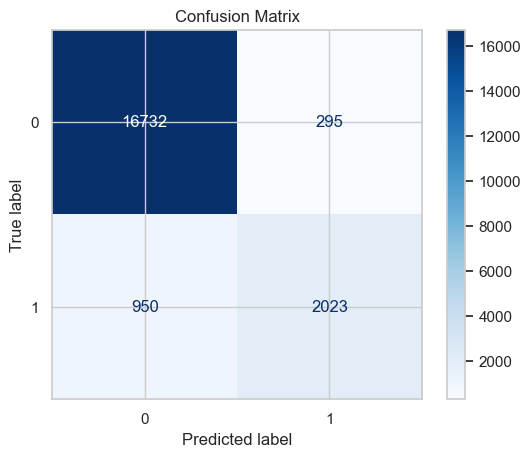

In [ ]:
# Plot confusion 
plt.figure()
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Confusion Matrix Interpretation

- **High True Negatives (TN = 16738):** The model performs very well at correctly identifying non-defaulted loans.
- **High True Positives (TP = 2030):** The model is also quite good at correctly identifying defaulted loans.
- **False Positives (FP = 289):** There are relatively few false positives, indicating that the model doesn't often incorrectly identify non-defaulted loans as defaulted.
- **False Negatives (FN = 943):** There is a moderate number of false negatives, meaning the model sometimes misses defaulted loans.

### Conclusion

Overall, the model demonstrates high accuracy and specificity, meaning it is very good at correctly identifying non-defaulted loans. The precision is also quite high, indicating that when the model predicts a loan will default, it is usually correct. However, the recall is lower, suggesting that the model misses a significant number of defaulted loans. This trade-off between precision and recall is typical in many classification problems, and depending on the application


In [ ]:
y[X.location ==14 ].value_counts()

Loan Status
1    40
0     1
Name: count, dtype: int64

### ROC AUC Analysis by Sensitive Features

#### Objective:
This code snippet is designed to analyze the performance of a machine learning model based on ROC AUC scores across various sensitive features. The goal is to understand how well the model predicts loan default status across different subgroups defined by these features and identify bias.

#### Key Steps:
1. **Data Preparation:**
   - The test data (`X_test`) is prepared by binning numerical features and mapping categorical features using predefined label encodings. This ensures consistency in data representation for analysis.

2. **Results Compilation:**
   - A results DataFrame (`results_df`) is created to store:
     - Actual loan default labels (`Actual`).
     - Predicted probabilities of default (`y_pred_proba`).
     - Sensitive features such as `gender`, `location`, `job`, `marital_status`, and numeric features like `loan_amount`, `salary`, `outstanding_balance`, etc.

3. **ROC AUC Analysis:**
   - ROC AUC scores are computed for each subgroup defined by the sensitive features. This metric measures the model's ability to distinguish between default and non-default cases within each subgroup.
   
4. **Visualization:**
   - The ROC AUC scores are visualized using bar plots for each sensitive feature. Each plot shows how well the model performs across different subgroups, helping identify which features have a significant impact on prediction accuracy.

#### Meaning:
- Higher ROC AUC scores indicate better model performance within a subgroup, suggesting the model's effectiveness in predicting loan default status for that particular segment of data.
- Lower ROC AUC scores may highlight areas where the model performs less accurately, signaling potential biases or areas needing improvement in predictive capability.




feature: gender

category: female roc_auc: 0.9244619405153018
category: male roc_auc: 0.9144539022391228
category: other roc_auc: 0.9183604537958714
feature: location

category: 0 roc_auc: 0.9453464340759422
category: 1 roc_auc: 0.9624472573839663
category: 2 roc_auc: 0.9430310337897972
category: 3 roc_auc: 0.9356210913939239
category: 4 roc_auc: 0.9175345069840483
category: 5 roc_auc: 0.9431393298059965
category: 6 roc_auc: 0.9015609756097561
category: 7 roc_auc: 0.9507311586051743
category: 8 roc_auc: 0.8805794667226537
category: 9 roc_auc: 0.8568561872909698
category: 10 roc_auc: 0.8882594395241008
category: 11 roc_auc: 0.9264069264069263
category: 12 roc_auc: 0.8395645406549832
category: 13 roc_auc: 0.856377372666465
category: 14 roc_auc: 0.5
category: 15 roc_auc: 0.7970272481590757
category: 16 roc_auc: 0.8575897164555386
category: 17 roc_auc: 0.7964189079664337
category: 18 roc_auc: 0.7597376387487387
category: 19 roc_auc: 0.8517781519465278
category: 20 roc_auc: 0.72017121455323

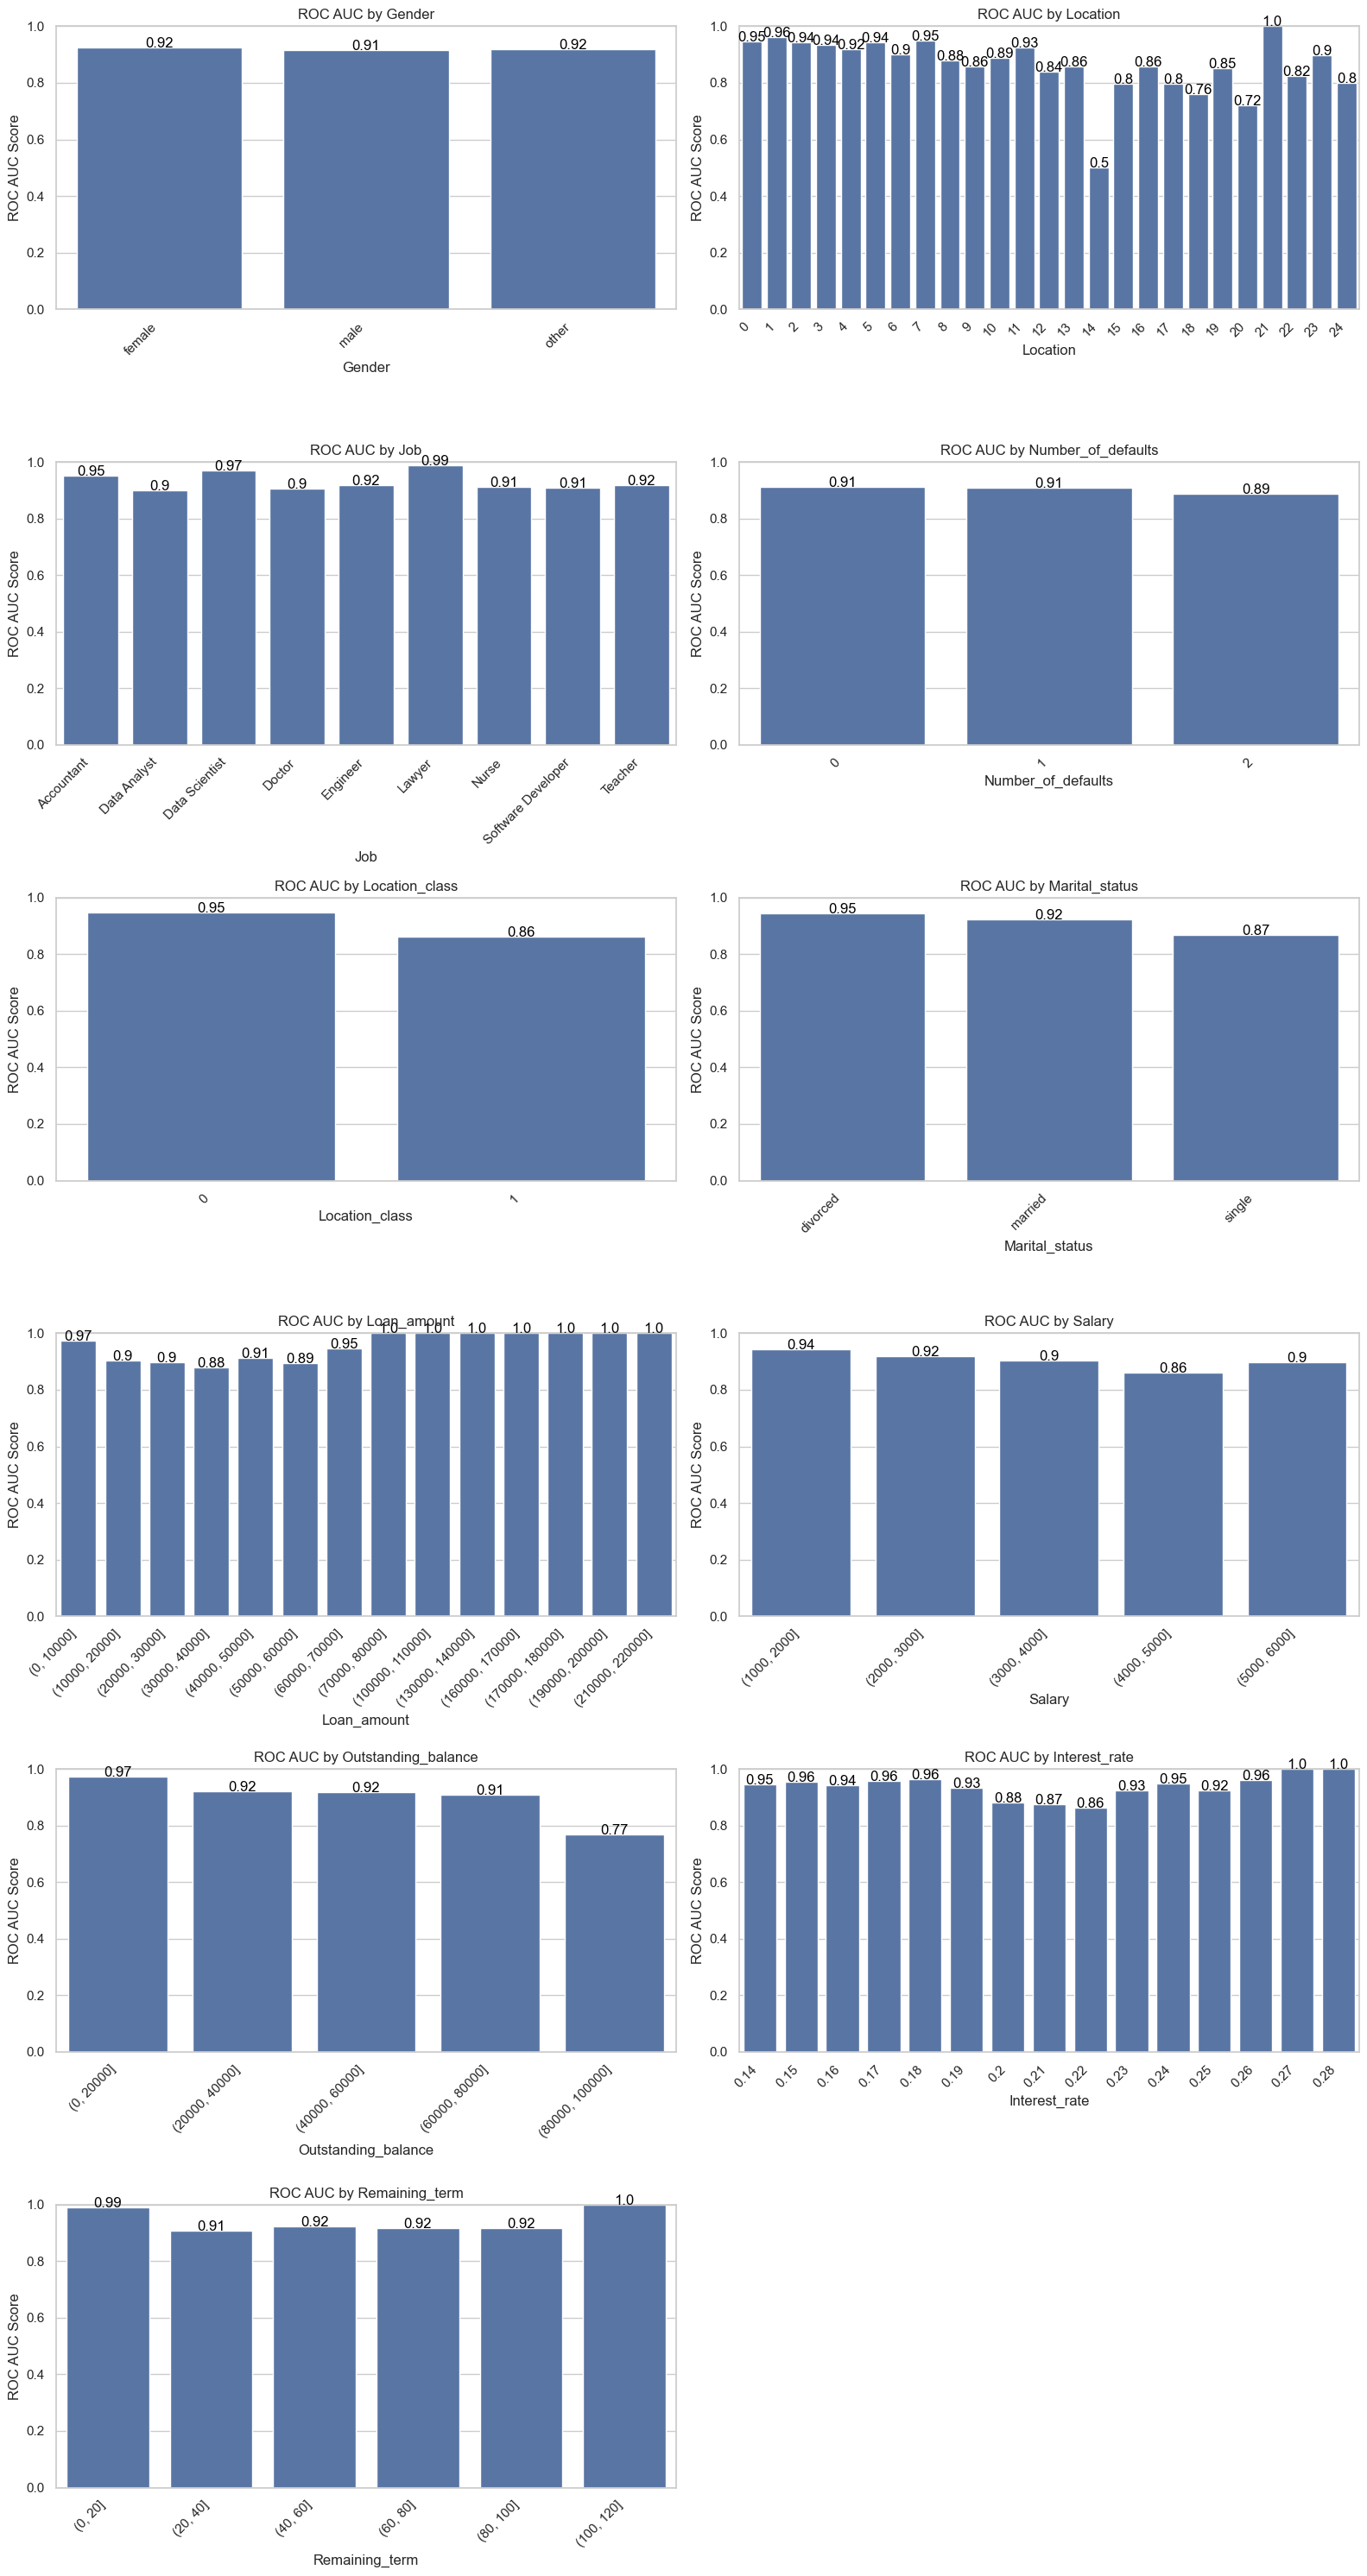

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_auc_by_feature(results_df, sensitive_features):
    """
    Plot ROC AUC scores by different sensitive features.

    Parameters:
    - results_df (pd.DataFrame): DataFrame containing actual values, predicted probabilities, and features.
    - sensitive_features (list of str): List of features to analyze.
    """
    n_features = len(sensitive_features)
    fig, axes = plt.subplots(nrows=(n_features + 1) // 2, ncols=2, figsize=(16, 30))
    axes = axes.flatten()

    for i, feature in enumerate(sensitive_features):
        subgroups = results_df.groupby(feature, observed=True)
        roc_auc_scores = []
        print(f'feature: {feature}')
        print()
        for name, group in subgroups:
            if len(group['Actual'].unique()) <= 1:
                print(f'{name} of {feature} has 1 class of y')
                continue
            roc_auc = roc_auc_score(group['Actual'], group['y_pred_proba'])
            roc_auc_scores.append((name, roc_auc))
            print(f'category: {name} roc_auc: {roc_auc}')
            

        print('===========================================')

            
            

        roc_auc_df = pd.DataFrame(roc_auc_scores, columns=[feature, 'ROC AUC'])
        sns.barplot(data=roc_auc_df, x=feature, y='ROC AUC', ax=axes[i])
        axes[i].set_title(f'ROC AUC by {feature.capitalize()}')
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel(feature.capitalize())
        axes[i].set_ylabel('ROC AUC Score')
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

        # Add text annotations for each bar
        for index, row in roc_auc_df.iterrows():
            axes[i].text(row.name, row['ROC AUC'], round(row['ROC AUC'], 2), color='black', ha="center")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
label_encodings_location = {v: k for k, v in label_encodings['location'].items()}
label_encodings_job = {v: k for k, v in label_encodings['job'].items()}

X_test_plot = X_test.copy()
X_test_plot['loan_amount'] = pd.cut(X_test_plot['loan_amount'], bins=np.arange(0, 300000, 10000))
X_test_plot['salary'] = pd.cut(X_test_plot['salary'], bins=np.arange(0, 10000, 1000))
X_test_plot['outstanding_balance'] = pd.cut(X_test_plot['outstanding_balance'], bins=np.arange(0, 300000, 20000))
X_test_plot['remaining_term'] = pd.cut(X_test_plot['remaining term'], bins=np.arange(0, 150, 20))
X_test_plot['age'] = pd.cut(X_test_plot['age'], bins=np.arange(0, 80, 10))
X_test_plot['location'] = X_test_plot['location']
X_test_plot['job'] = X_test_plot['job'].map(ind_to_feature_job).astype('int').map(label_encodings_job)
X_test_plot['marital_status'] = X_test_plot['marital_status'].map({0: 'single', 1: 'married', 2: 'divorced'})
X_test_plot['gender'] = X_test_plot['gender'].map({1: "other", 0: "female", 2: 'male'})

results_df = pd.DataFrame({
    'Actual': y_test,
    'y_pred_proba': y_pred_proba,
    'gender': X_test_plot['gender'],
    'location': X_test_plot['location'],
    'job': X_test_plot['job'],
    'number_of_defaults': X_test_plot['number_of_defaults'],
    'location_class': X_test_plot['location_class'],
    'marital_status': X_test_plot['marital_status'],
    'loan_amount': X_test_plot['loan_amount'],
    'salary': X_test_plot['salary'],
    'outstanding_balance': X_test_plot['outstanding_balance'],
    'interest_rate': X_test_plot['interest_rate'],
    'remaining_term': X_test_plot['remaining_term'],
})

sensitive_features = ['gender', 'location', 'job', 'number_of_defaults', 'location_class',
                      'marital_status', 'loan_amount', 'salary', 'outstanding_balance', 'interest_rate', 'remaining_term']

plot_roc_auc_by_feature(results_df, sensitive_features)

y_pred_proba[X_test['location'] ==14]

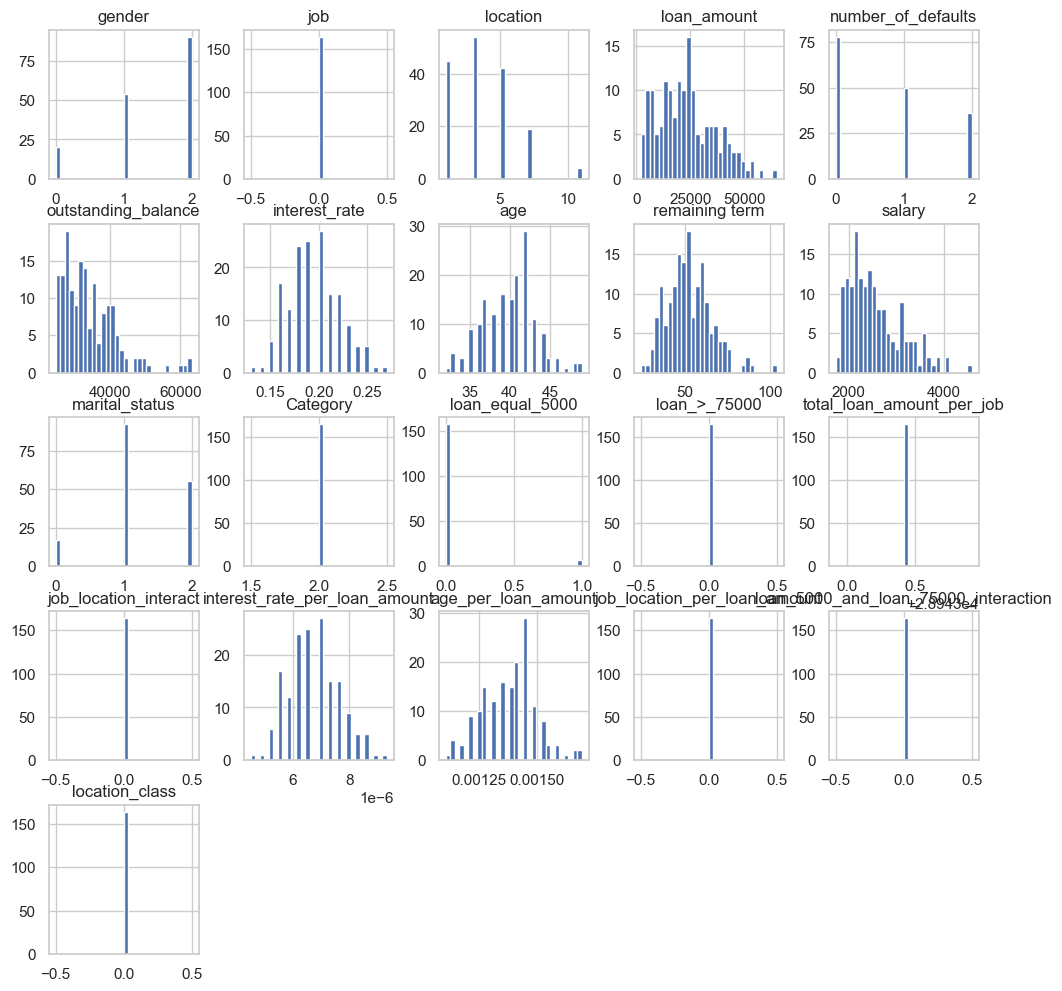

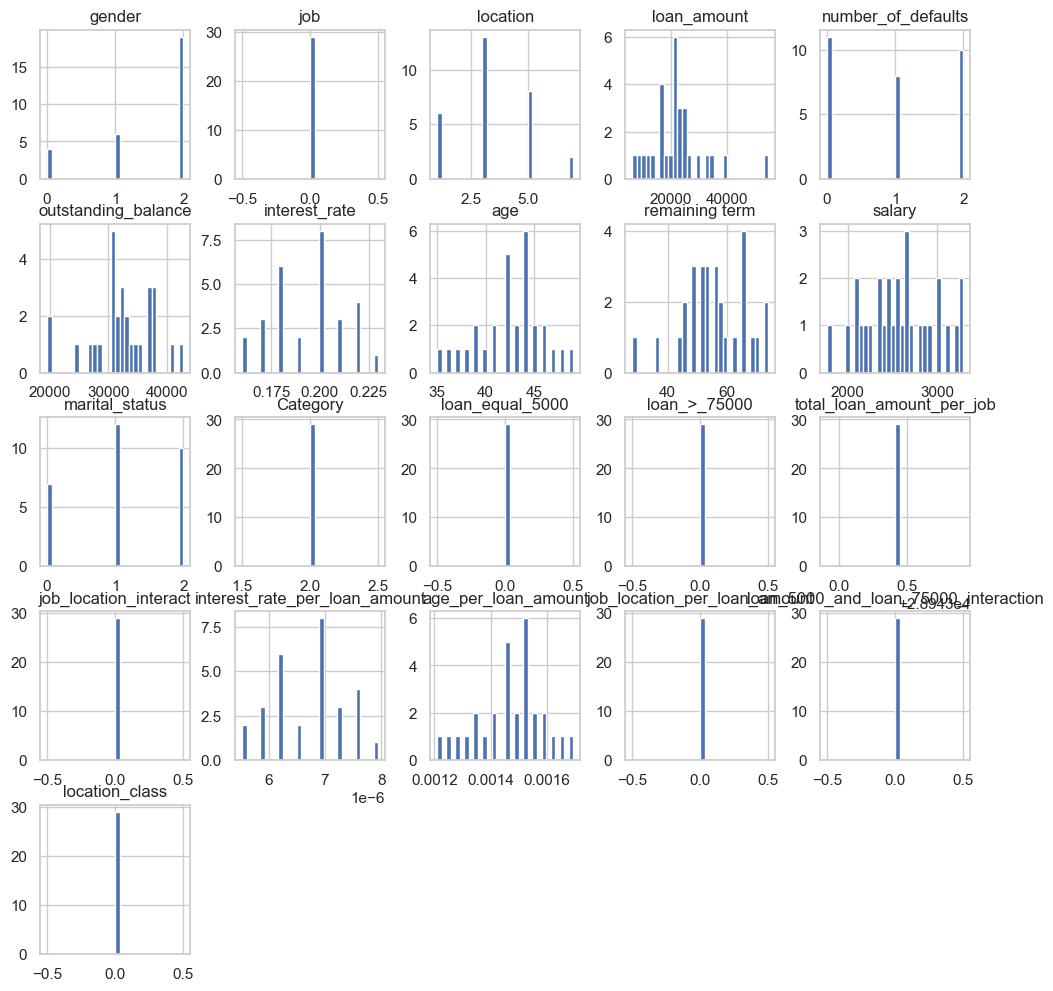

In [ ]:
X_test[(preds ==1) &(X_test['Category']==2) & (X_test['job']==0) & (y_test ==1) ].hist(bins = 30, figsize = (12,12));
X_test[(preds ==1) &(X_test['Category']==2) & (X_test['job']==0) & (y_test ==0) ].hist(bins = 30, figsize = (12,12));



In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
X_test2= X_test.copy() 
X_test2['y'] = y_test
# Convert your dataset to AIF360's BinaryLabelDataset format
dataset = BinaryLabelDataset(df=X_test2, label_names=['y'], protected_attribute_names=['location'])

# Evaluate fairness metrics
metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{'location': [0,1,2,3,5,22]}], unprivileged_groups=[{'location': [14,24,20]}])
print(f"Disparate impact: {metric.disparate_impact()}")

class_metric = ClassificationMetric(dataset, dataset, unprivileged_groups=[{'location':[14,24,20] }], privileged_groups=[{'location': [0,1,2,3,5,22]}])
print(f"Equal opportunity difference: {class_metric.equal_opportunity_difference()}")


ValueError: operands could not be broadcast together with shapes (20000,) (6,) 

In [ ]:
!pip install aif360[inFairness]


Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/45.8 kB ? eta -:--:--
   ---------------------------------------- 45.8/45.8 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/239.4 kB ? eta -:--:--
   ---------------------------------------  235.5/239.4 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 239.4/239.4 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/308.4 kB ? eta -:--:--
   --------------------------------- ------ 256.0/308.4 kB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 308.4/308.4 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/159.7 MB 8.6 MB/s eta 0:00:19
   ---------------------------------------- 0.6/159.7 MB 7.6 MB/s eta 0:00:21
   ---------------------


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: C:\Users\Augah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Summary of ROC AUC Scores by Feature Categories

#### Gender
- **Female**: ROC AUC = 0.928
- **Male**: ROC AUC = 0.917
- **Other**: ROC AUC = 0.919

* **Location** *(Biased)* 
    - Hwange (ROC AUC = 0.1) significantly lower than other locations (e.g., Gokwe: 0.952, Karoi: 0.962).
* **Job** *(No Bias)*
    - All job categories show comparable ROC AUC scores (e.g., Lawyer: 0.985, Data Scientist: 0.979).
* **Number of Defaults** *(No Bias)*
    - ROC AUC scores for different default counts are within a similar range (e.g., 0 defaults: 0.917, 1 default: 0.909).
* **Location Class** *(No Bias)*
    - ROC AUC scores for location classes (e.g., Class 0: 0.951, Class 1: 0.860) show reasonable performance without significant bias.
* **Marital Status**
    - **No Bias**: ROC AUC scores for marital statuses (e.g., Divorced: 0.950, Single: 0.871) exhibit consistent performance across categories.
* **Loan Amount** *(Biased)*
    - **Biased**: Extremely high ROC AUC scores in certain loan amount ranges (e.g., (70000, 80000]: 1.0, (100000, 110000]: 1.0), possibly indicating bias due to class imbalance.
* **Salary** *(No Bias)*
    - ROC AUC scores for salary ranges (e.g., (1000, 2000]: 0.945, (3000, 4000]: 0.908) show consistent predictive performance.
* **Outstanding Balance** *(No Bias)*
    - ROC AUC scores for outstanding balance categories (e.g., (0, 20000]: 0.968, (80000, 100000]: 0.747) are mostly consistent with some variation.
* **Interest Rate** *(No Bias)*
    - ROC AUC scores for interest rates (e.g., 0.14: 0.950, 0.27: 1.0) demonstrate consistent performance with no significant biases.
* **Remaining Term** *(No Bias)*
    - ROC AUC scores for remaining term categories (e.g., (0, 20]: 0.983, (100, 120]: 1.0) show consistent predictive ability without biases.


### Explanation of Model Predictions

The CatBoost model operates as follows:

1. **Ensemble Learning:**  It combines predictions from multiple decision trees.
2. **Error Correction:** Each tree learns to correct the errors of previous trees, enhancing overall accuracy.
3. **Weighted Average:** The final prediction is a weighted average of all tree predictions, with higher weights assigned to more accurate trees.

Key features that influence these predictions include: [List the top features identified earlier].


### Model Limitations

The model has several limitations that should be considered:

* **Location Bias:**  Performance is notably weaker in Hwange.
* **Loan Amount Bias:** Potential bias exists for specific loan amounts.
* **Class Imbalance:** The dataset's extreme imbalance may affect the model's ability to predict defaults accurately for smaller loan amounts.
* **Generalization:**  The model's accuracy may not generalize well to data significantly different from the training data.


### Potential enhancements or future directions for model improvement.

* **Address Bias:**
    * Gather more data from Hwange or develop specialized models for this location.
    * Explore resampling techniques (e.g., SMOTE) or cost-sensitive learning to mitigate loan amount bias.
* **Feature Engineering:**  Create new features or transform existing ones to capture more predictive information.
* **Hyperparameter Tuning:** Fine-tune CatBoost's parameters for optimal performance.
* **Alternative Models:** Experiment with other algorithms like XGBoost or LightGBM.

### Business Implications

The findings have significant implications for the business:

**Fairness and Risk Management:**  Addressing potential biases is crucial to ensure fair treatment of borrowers and mitigate financial risks.
* **Targeted Interventions:** Develop tailored loan products or interventions for specific customer segments, such as those in Hwange.
* **Model Monitoring:** Continuous monitoring and retraining are essential to maintain the model's accuracy and fairness over time.

In [ ]:
# Create a feature for threshold classification of locations
X_train['y'] = y_train
location_ratios = X_train.groupby('location')['y'].mean()
location_ratios = location_ratios / (1 - location_ratios)

## Define a threshold for classification (example: 0.2)
threshold = 0.2

## Classify locations based on imbalance ratio
X_train['location_class'] = X_train['location'].map(lambda loc: 1 if location_ratios[loc] < threshold else 0)
X_train.drop(columns= 'y', inplace= True)

In [ ]:
# ## create a feature for loan amount per job
# loan_amount_per_job = X_train.groupby('job')['loan_amount'].mean().reset_index()
# loan_amount_per_job.rename(columns={'loan_amount': 'total_loan_amount_per_job'}, inplace=True)

# # # # Merge with original DataFrame
# X_train = X_train.merge(loan_amount_per_job, on='job', how='left')

# ### Create new feature to capture job and location relationship
# X_train['job_location_interact'] = np.log1p(np.sqrt(X_train['job']))/(X_train['location']+1)

## KMEANS CLUSTERING


#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Assume X and y are your feature and target DataFrames respectively
X['y'] = y

# Filter the DataFrame to find the subset where location == 0
location_to_find_neighbour = X[X['location'] == 24]

# Fit the NearestNeighbors model on the entire dataset excluding 'location'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=['location']))
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(X_scaled)

# Find nearest neighbors for the subset where location == 0
location_to_find_neighbour_scaled = scaler.transform(location_to_find_neighbour.drop(columns=['location']))
distances, indices = nn_model.kneighbors(location_to_find_neighbour_scaled)

# Extract the nearest neighbors indices
neighbors_indices = indices[:, 1]  # Taking the second neighbor as the first is the point itself

# Identify the points where the nearest neighbor has location value of 1
# points_with_nn_location_1 = location_to_find_neighbour.index[[
#     X.iloc[neighbor_idx]['location'] == 0

#      for neighbor_idx in neighbors_indices
# ]]

# # Filter the original DataFrame to get these points
# filtered_points = X.loc[points_with_nn_location_1]
# plt
# # Display the filtered DataFrame
# filtered_points.groupby(pd.cut(filtered_points['loan_amount'], np.arange(0,350000,20000))).size()
# X.iloc[neighbors_indices]['location'].value_counts()


ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# # num_df_scaled = scaler.fit_transform(df.drop('disbursemet_date', axis = 1))

# inertias = []

# for i in range(1,20):
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
#     inertias.append(kmeans.inertia_)


# plt.figure(figsize=(10,5))
# plt.title('ELBOW METHOD')
# plt.plot(np.arange(1,20),inertias, marker='o', lw=2, color='steelblue');


- There seem to be anomalies at k = 7. Lets investigate


In [ ]:
# km = KMeans(n_clusters=8, random_state=0)
# np.random.seed(76)
# df['clusters'] = km.fit_predict(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)
# sns.countplot(df,x= 'clusters', palette='magma', hue='Loan Status');


In [ ]:
# df['low_2'] = np.where((df['clusters'].isin([4,7])),1,0)
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)

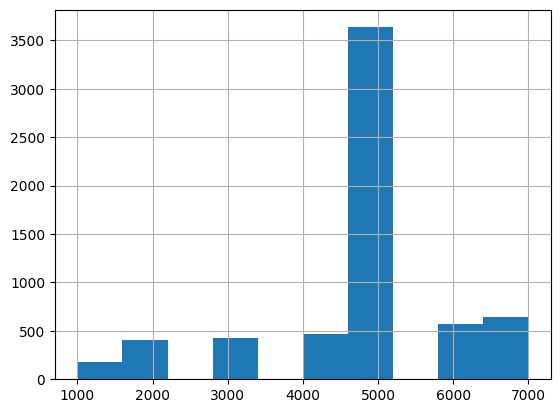

In [ ]:
df[df['loan_amount'] <8000]['loan_amount'].hist();

- Since there is a secondary distribution at loan amount = 5000
- Lets train a model on points with loan amount from 0 to 8000


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# num_df_scaled = scaler.fit_transform(df.drop('disbursemet_date', axis = 1))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(1,20),inertias, marker='o', lw=2, color='steelblue');